Imports

In [1]:
from drawing_bot_api.trajectory_optimizer.shape_generator import ShapeGenerator
from drawing_bot_api.trajectory_optimizer.shape_generator import RESTING_POINT
from drawing_bot_api import DrawingBot
from drawing_bot_api.trajectory_optimizer.image_processor import ImageProcessor
from drawing_bot_api.trajectory_optimizer.wiper import Wiper
from drawing_bot_api.trajectory_optimizer.simulator import PatternErrorSim
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from drawing_bot_api.trajectory_optimizer.training_v3 import Trainer
import signal
from drawing_bot_api.trajectory_optimizer.config import *
from scipy.ndimage import gaussian_filter1d
import tensorflow as tf 
tf.compat.v1.enable_eager_execution()
from ipyparallel import Client
from multiprocessing import TimeoutError
import time
import gc
from IPython.display import clear_output

2025-01-10 12:58:23.600746: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from IPython.core.interactiveshell import InteractiveShell

# Display all elements without truncation
InteractiveShell.ast_node_interactivity = "all"

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


In [3]:
DEBUG_MODE = False
TEST_MODE = True

In [4]:
shape_generator = ShapeGenerator()
drawing_bot = DrawingBot()
image_processor = ImageProcessor()
wiper = Wiper()
error_simulator = PatternErrorSim(strength=15, pattern_length=20, seed=1)
model = Trainer()
reward_log = []

Unit set to "mm".


In [5]:
# handler for timeout
def handler(signum, frame):
    raise TimeoutError("Operation timed out")

signal.signal(signal.SIGALRM, handler)


<Handlers.SIG_DFL: 0>

In [6]:
def plot_graph(data, labels):
    for _i in range(len(data)):
        plt.plot(data[_i], label=labels[_i])
    plt.legend(bbox_to_anchor=(1, 1.15), ncol=3)  
    plt.show() 

In [7]:
TEST_SHAPE = shape_generator(seed=1)
for shape in TEST_SHAPE:
    drawing_bot.add_shape(shape)
TEST_TRAJECTORY = np.array(drawing_bot._get_all_points())
TEST_TEMPLATE = np.array(drawing_bot.plot(training_mode=True, points=TEST_TRAJECTORY))
drawing_bot.shapes.clear()

def get_template():
    if TEST_MODE:
        return TEST_TRAJECTORY, TEST_TEMPLATE
    
    for shape in shape_generator(seed=1):
        drawing_bot.add_shape(shape)
    # get template for drawing
    trajectory = np.array(drawing_bot._get_all_points())
    template = np.array(drawing_bot.plot(training_mode=True, points=trajectory))
    drawing_bot.shapes.clear()
    
    return trajectory, template

In [8]:

def get_adjusted_trajectory(trajectory, exploration_factor):
    adjusted_trajectory = np.array(model.adjust_trajectory(trajectory, exploration_factor=exploration_factor))
    adjusted_template = np.array(drawing_bot.plot(training_mode=True, points=adjusted_trajectory))
    return adjusted_trajectory, adjusted_template


In [9]:
def simulate_drawing(adjusted_trajectory):    
    simulated_trajctory = error_simulator(adjusted_trajectory)
    drawing = np.array(drawing_bot.plot(training_mode=True, points=simulated_trajctory))
    return simulated_trajctory, drawing


In [10]:
def calc_reward(similarity, type='default'):
    if type == 'default':
        return similarity
    
    elif type == 'avoid_zero':
        THRESHOLD = 0.5
        if similarity > THRESHOLD:
            return similarity
        else:
            return (((1-THRESHOLD)/THRESHOLD)*similarity - 1)
        
    elif type == 'inverted':
        return 1 - similarity

In [11]:
def get_images_of_individual_points(trajectory, resolution):
    _images = [] 
    _points = np.array(trajectory)

    for _index in range(0, int(len(_points)), resolution):
        _images.append(drawing_bot.plot(training_mode=True, points=_points[_index:_index+resolution]))
    plt.close('all')
    return _images

In [12]:
def fit_model(template, drawing, train_actor, trajectory, individual_reward=True):
    if individual_reward:
        resolution = 16
        images_of_individual_points = get_images_of_individual_points(trajectory, resolution)
        rewards = np.array(image_processor.calc_rewards_for_individual_points(images_of_individual_points, drawing))
        rewards = np.repeat(rewards, resolution, axis=0)
        rewards = np.nan_to_num(rewards, nan=1)
        #rewards = np.append(rewards, np.ones(len(trajectory)-len(rewards)))
        critic_rewards = model.train(rewards, train_actor)
        
        del images_of_individual_points

        return np.mean(rewards), critic_rewards
    else:
        similarity = image_processor(template, drawing=drawing)
        if similarity is None:
            return None
        reward = calc_reward(similarity, type='default')
        sub_rewards = model.train(reward, train_actor)
        return reward, sub_rewards

In [13]:
def save_assigned_reward_img(trajectory, rewards):
    reward_assigned_drawing = drawing_bot.plot(training_mode=True, points=trajectory, color_assignment=rewards)
    image_processor.save_image(reward_assigned_drawing, 'rewarded', 'rewarded_drawing')
    image_processor.call_counter += 1
    del reward_assigned_drawing

In [14]:
def training_cycle(cycle_index, num_of_cycles):
    signal.alarm(10)

    try:
        trajectory, template = get_template()

        random_action_prob = 0
        RANDOM_CUTOFF = 1000
        if cycle_index < RANDOM_CUTOFF:
            random_action_prob = np.random.random() * (0.015 - (cycle_index/(RANDOM_CUTOFF * 100))) + 0.000001# * pow(0.998, cycle_index)# - (cycle_index/(12*num_of_cycles))
        
        train_actor = False
        if cycle_index > 150:
            train_actor = True

        #print(f'Exploration factor: {exploration_factor}')
        adjusted_trajectory, adjusted_template = get_adjusted_trajectory(trajectory, random_action_prob)
        simulated_trajectory, drawing = simulate_drawing(adjusted_trajectory)
        reward, sub_rewards = fit_model(template, drawing, train_actor, trajectory, individual_reward=True)
        if cycle_index % SAVE_IMAGE_FREQ == 0:
            save_assigned_reward_img(simulated_trajectory, sub_rewards)
            image_processor.save_image(drawing, 'original', 'drawing')
        
        del adjusted_trajectory, adjusted_template, simulated_trajectory, drawing, trajectory, template
        
        if not reward is None:
            reward_log.append(reward)
            print(f'{bcolors.HEADER}Cylce: {cycle_index}\t{bcolors.ENDC}Exploration factor: {random_action_prob}\t{bcolors.OKCYAN}Reward: {reward_log[-1]}{bcolors.ENDC}')
        
            if reward > 1:
                return 1
    
    except TimeoutError as e:
        if DEBUG_MODE:
            raise
        else:
            print(f"Timeout occurred: {e}")

    finally:
        signal.alarm(0)  # Cancel the alarm
        if 0:
            gc.collect()
    


Critic | mean: 2.770829677581787	var: 0.7677708864212036	min: 0.39442992210388184	max: 4.121074199676514
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.1018 
Cylce: 19	Exploration factor: 0.0054729935478971	Reward: 0.9067729517626434


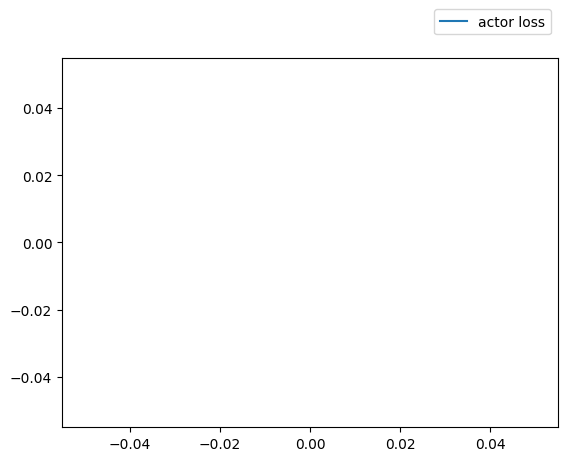

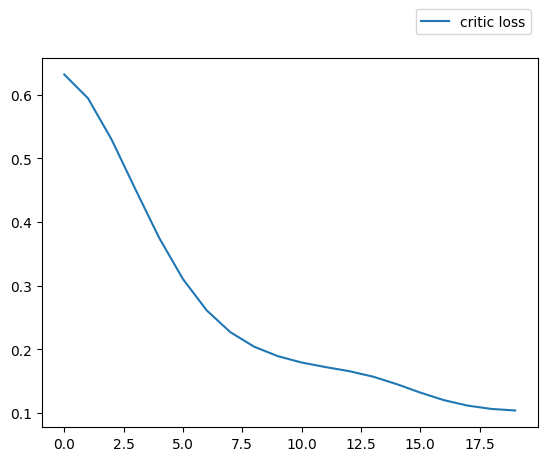

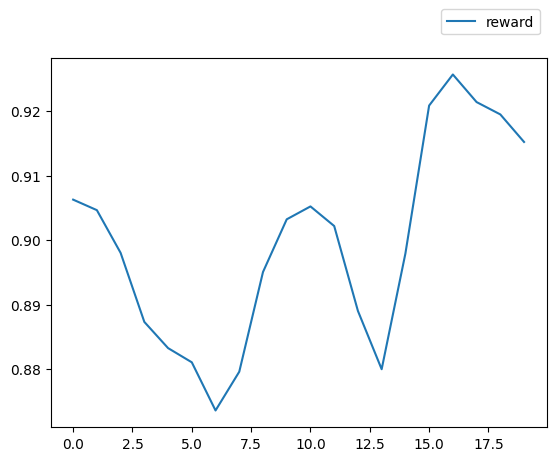

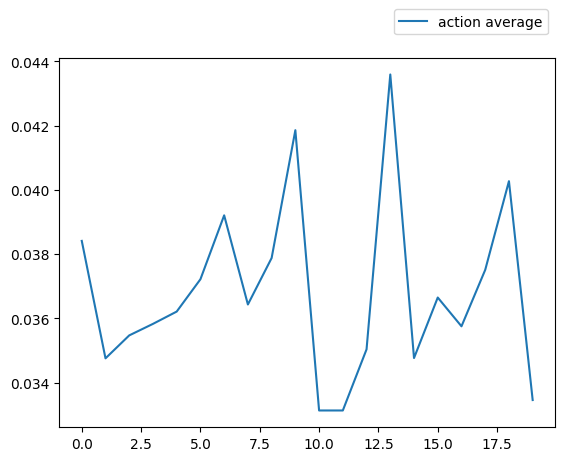

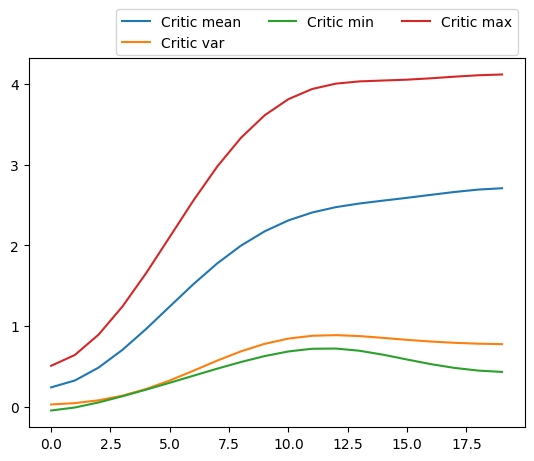

In [15]:
NUM_OF_CYCLES = 20
inital_weights = []

for layer in model.critic.layers:
    inital_weights.append(layer.get_weights()[0])

for i in range(NUM_OF_CYCLES):
    clear_output(wait=True)
    #print(f'Cylce: {i}')
    if training_cycle(i, NUM_OF_CYCLES):
        break
    plt.close('all')

%matplotlib inline

#plot rewards and losses
reward_log = gaussian_filter1d(reward_log, sigma=1)
loss_history_actor = gaussian_filter1d(model.loss_history_actor.losses, sigma=2)
loss_history_critic = gaussian_filter1d(model.loss_history_critic.losses, sigma=2)
critic_mean = gaussian_filter1d(model.critic_mean_history, sigma=2)
critic_var = gaussian_filter1d(model.critic_var_history, sigma=2)
critic_min = gaussian_filter1d(model.critic_min_history, sigma=2)
critic_max = gaussian_filter1d(model.critic_max_history, sigma=2)

end_weights = []
for layer in model.critic.layers:
    end_weights.append(layer.get_weights()[0])

#print(f'\nInitial weights:\n{inital_weights}')
#print(f'\n\nWeights in the end:\n{end_weights}\n')

plot_graph([loss_history_actor], ['actor loss'])
plot_graph([loss_history_critic], ['critic loss'])
plot_graph([reward_log], ['reward'])
plot_graph([model.absolute_average_action_history], ['action average'])
plot_graph([critic_mean, critic_var, critic_min, critic_max], ['Critic mean', 'Critic var', 'Critic min', 'Critic max'])